# How to Fit Grid Models to Data

In this notebook, we show how to use the `PICASO`-formatted grid models to interpret data. We will use the results of the [JWST Transiting Exoplanet Community Early Release Science Team's](https://arxiv.org/pdf/2208.11692.pdf) first look analysis of WASP-39 b.

**Helpful knowledge before running this notebook:**

- [How to use xarray files](https://natashabatalha.github.io/picaso/notebooks/codehelp/data_uniformity_tutorial.html) 
- [Basic PICASO knowledge of how to compute transit spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ESO2021/ESO_Tutorial.html)

**Need to do before running this notebook**

In order to use this notebook you will have to: 

- [Download and unpack the zenodo grid models](https://doi.org/10.5281/zenodo.7236759)
- [Download the final planet spectrum](https://zenodo.org/record/6959427#.Y1M0U-zMLvU) 

In [17]:
import numpy as np
import os

import picaso.justdoit as jdi
import picaso.justplotit as jpi
import picaso.analyze as lyz
jpi.output_notebook()

Loading BokehJS ...

## Define Paths To Data and Models

You should have four folders in your `model_dir`: 

1. `RCTE_cloud_free/`: 192 models 
2. `RCTE_cloudy/`: 3840 models 
3. `photochem_cloud_free/`: 116 models
4. `photochem_cloudy/`: 580 models 


In [19]:
#should have sub folders similar to above
#agnostic to where it is, just make sure you point to the right data file
model_dir = "/data2/models/WASP-39B/xarray/"

#downloaded and unzipped from Zenodo
data_dir = '/data2/observations/WASP-39b/ZENODO/TRANSMISSION_SPECTRA_DATA/'
#for this tutorial let's grab the firely reduction
data_file = os.path.join(data_dir,"FIREFLY_REDUCTION.txt")

wlgrid_center,rprs_data2,wlgrid_width, e_rprs2 = np.loadtxt(data_file,usecols=[0,1,2,3],unpack=True,skiprows=1)

#for now, we are only going to fit 3-5 um
wh =  np.where(wlgrid_center < 3.0)
wlgrid_center = np.delete(wlgrid_center,wh[0])
wlgrid_width = np.delete(wlgrid_width,wh[0])
rprs_data2 = np.delete(rprs_data2,wh[0])
e_rprs2 = np.delete(e_rprs2,wh[0])
reduction_name = "Firefly"

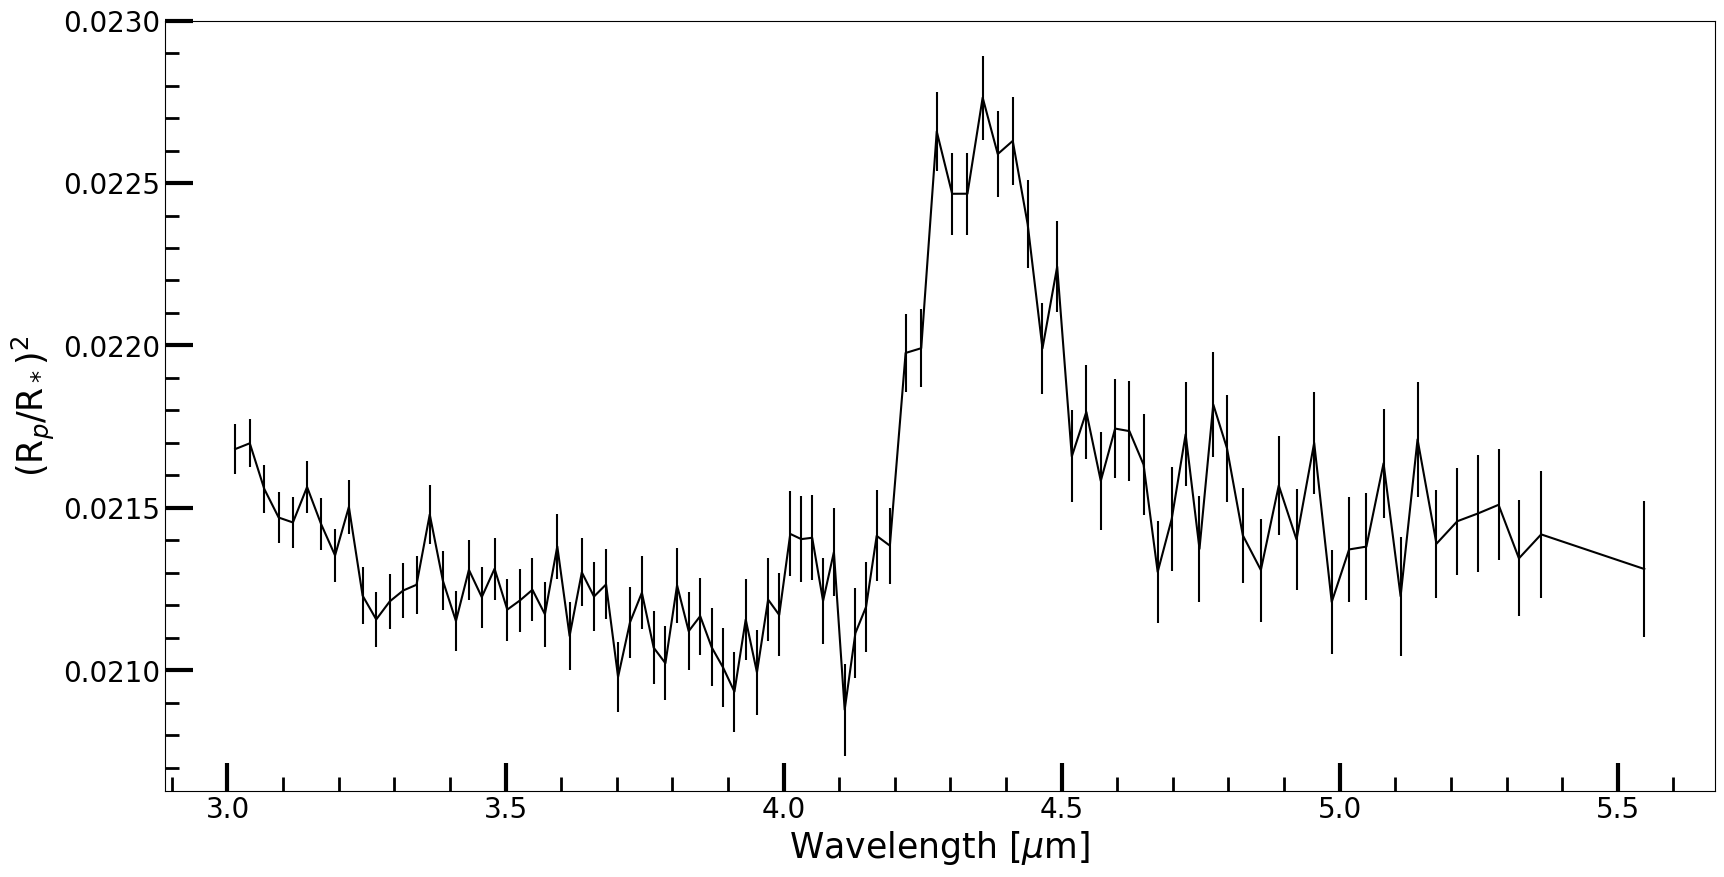

In [20]:
f=jpi.plot_errorbar(wlgrid_center, rprs_data2,e_rprs2, plot_type='matplotlib',
                   plot_kwargs={'ylabel':r'(R$_p$/R$_*$)$^2$'})#plot_type='bokeh' also available
#jpi.show(f) #if using bokeh (note if using bokeh need those key words (e.g. y_axis_label instead of ylabel))

## Add Available Grids to Test

First step will be to load your first grid into the `GridFitter` class. You can do this easily by supplying the function a directory location, and grid name (`grid_name`). 

The only purpose of `grid_name` is in case you add more grids to your `GridFitter` function, it will be easy to keep track of what parameters go with what grid.  

In [21]:
grid_name = "picaso_cld_free"
location = os.path.join(model_dir,"RCTE_cloud_free")
fitter = lyz.GridFitter(grid_name,location, verbose=True)

Total number of models in grid is 192
For tint in planet_params grid is: [100. 200. 300.]
For heat_redis in planet_params grid is: [0.4 0.5]
For mh in planet_params grid is: [  0.1     0.316   1.      3.162  10.     31.623  50.119 100.   ]
For cto in planet_params grid is: [0.229 0.458 0.687 0.916]


This shows you what parameters the grid was created over

In [22]:
fitter.grid_params['picaso_cld_free']['planet_params'].keys()

dict_keys(['tint', 'heat_redis', 'mh', 'cto'])

In [23]:
location = os.path.join(model_dir,"RCTE_cloudy")
fitter.add_grid('picaso_cldy', location)#

Total number of models in grid is 3840
For tint in planet_params grid is: [100. 200. 300.]
For heat_redis in planet_params grid is: [0.4 0.5]
For logkzz in planet_params grid is: [ 5.  7.  9. 11.]
For mh in planet_params grid is: [  0.1     0.316   1.      3.162  10.     31.623  50.119 100.   ]
For cto in planet_params grid is: [0.229 0.458 0.687 0.916]
For fsed in cld_params grid is: [ 0.6  1.   3.   6.  10. ]


### Explore the parameters of the grid

You can see what grids you have loaded

In [24]:
fitter.grids #what grids exist

['picaso_cld_free', 'picaso_cldy']

You can also see what the top level information about your grid is

In [25]:
fitter.overview['picaso_cld_free']#top level info from the attrs 

{'planet_params': {'rp': 1.279,
  'mp': 0.28,
  'tint': array([100., 200., 300.]),
  'heat_redis': array([0.4, 0.5]),
  'p_reference': 10.0,
  'logkzz': 'Not used in grid.',
  'mh': array([  0.1  ,   0.316,   1.   ,   3.162,  10.   ,  31.623,  50.119,
         100.   ]),
  'cto': array([0.229, 0.458, 0.687, 0.916]),
  'p_quench': 'Not used in grid.',
  'rainout': 'Not used in grid.',
  'teff': nan,
  'logg': nan,
  'm_length': nan},
 'stellar_params': {'rs': 0.932,
  'logg': 4.38933,
  'steff': 5326.6,
  'feh': -0.03,
  'ms': 0.913},
 'cld_params': {'opd': 'Not used in grid.',
  'ssa': 'Not used in grid.',
  'asy': 'Not used in grid.',
  'p_cloud': 'Not used in grid.',
  'haze_eff': nan,
  'fsed': 'Not used in grid.'},
 'num_params': 4}

The full list of planet parameters can also be cross referenced against the full list of file names so you can easily plot of different models. 

In [26]:
print(fitter.grid_params['picaso_cld_free']['planet_params']['tint'][0], 
#this full list can be cross referened against the file list 
fitter.list_of_files['picaso_cld_free'][0])
#in this case we can verify against the filename

200.0 model_dir/xarrays/RCTE_cloud_free/profile_eq_planet_200_grav_4.5_mh_+0.0_CO_1.5_sm_0.0486_v_0.4_.nc


## Add Datasets to Explore

Though the models are interesting, what we are really after is which is most representative of the data. So now let's add some datasets to explore. 

In [27]:
fitter.add_data('firefly',wlgrid_center, wlgrid_width, rprs_data2, e_rprs2)

## Compute $\chi_{red}^2$/N and Retrieve Single Best Fit

In this analysis we used the reduced chi sq per data point as a metric to fit the grid. This fitter function will go through your whole grid and compute cross reference the chi sq compared to your data. 

In [28]:
fitter.fit_grid('picaso_cld_free','firefly')
fitter.fit_grid('picaso_cldy','firefly')

Now that we have accumulated results let's turn this into a dictionary to easily see what we've done

In [29]:
out = fitter.as_dict()#allows you to easily grab data
out.keys()

dict_keys(['list_of_files', 'spectra_w_offset', 'rank_order', 'grid_params', 'offsets', 'chi_sqs', 'posteriors'])

We are most interested in the models with the best reduced chi sq. We can use our ranked order to get the models that best fit the data. 

In [30]:
### Use rank order to get the top best fit or other parameters
#top 5 best fit models metallicities for the cloud free grid
print("cld free",np.array(out['grid_params']['picaso_cld_free']['planet_params']['mh']
        )[out['rank_order']['picaso_cld_free']['firefly']][0:5])

#top 5 best fit models metallicities for the cloudy grid
print("cldy",np.array(out['grid_params']['picaso_cldy']['planet_params']['mh']
        )[out['rank_order']['picaso_cldy']['firefly']][0:5])

cld free [100. 100. 100. 100. 100.]
cldy [ 3.162 10.    10.    10.    10.   ]


Interesting! We are already seeing interesting information. Without clouds our model predicts higher metallicity than when we add clouds. Let's look at the associated chi square values. 

In [31]:
#top 5 best fit chi sqs for the cloud free grid
print("cld free", np.array(out['chi_sqs']['picaso_cld_free']['firefly']
        )[out['rank_order']['picaso_cld_free']['firefly']][0:5])
      
#top 5 best fit chi sq for the cloudy grid
print("cldy", np.array(out['chi_sqs']['picaso_cldy']['firefly']
        )[out['rank_order']['picaso_cldy']['firefly']][0:5])

cld free [1.91987567 1.92849109 1.9556125  2.00119925 2.01856747]
cldy [1.32818737 1.37253841 1.37564302 1.39244227 1.39555045]


The cloudy grid is giving lower chi square giving us clues that this planet likely has clouds affecting the spectrum.

## Analyze Single Best Fits

Let's analyze the single best fits in order to compare the spectrum with the data

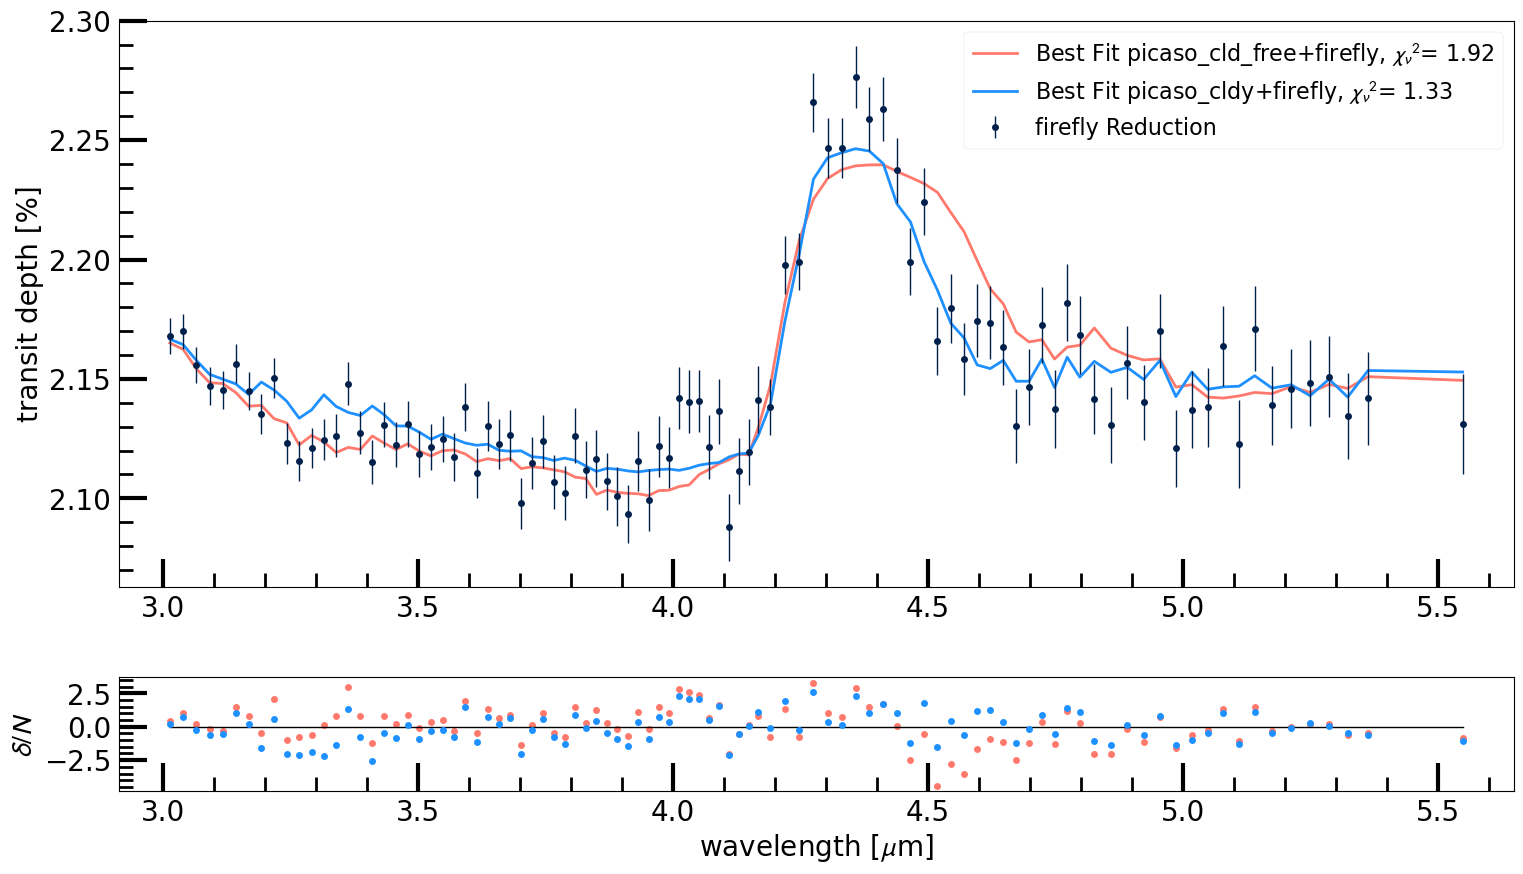

In [32]:
fig,ax = fitter.plot_best_fit(['picaso_cld_free','picaso_cldy'],'firefly')

By-eye, our cloudy grid is giving a much better representation of the data. Let's look at what physical parameters are associated with this. 

In [33]:
best_fit = fitter.print_best_fit('picaso_cldy','firefly')

tint=100.0
heat_redis=0.5
logkzz=9.0
mh=3.162
cto=0.458
fsed=0.6


You can see these same parameters reported in original Nature paper: https://arxiv.org/pdf/2208.11692.pdf

## Estimated Posteriors 

It is also helpful to get an idea of what the probability is for each grid parameter in your model. This will give you a better representation of degeneracies that exist with your data and each of your physical parameters. 

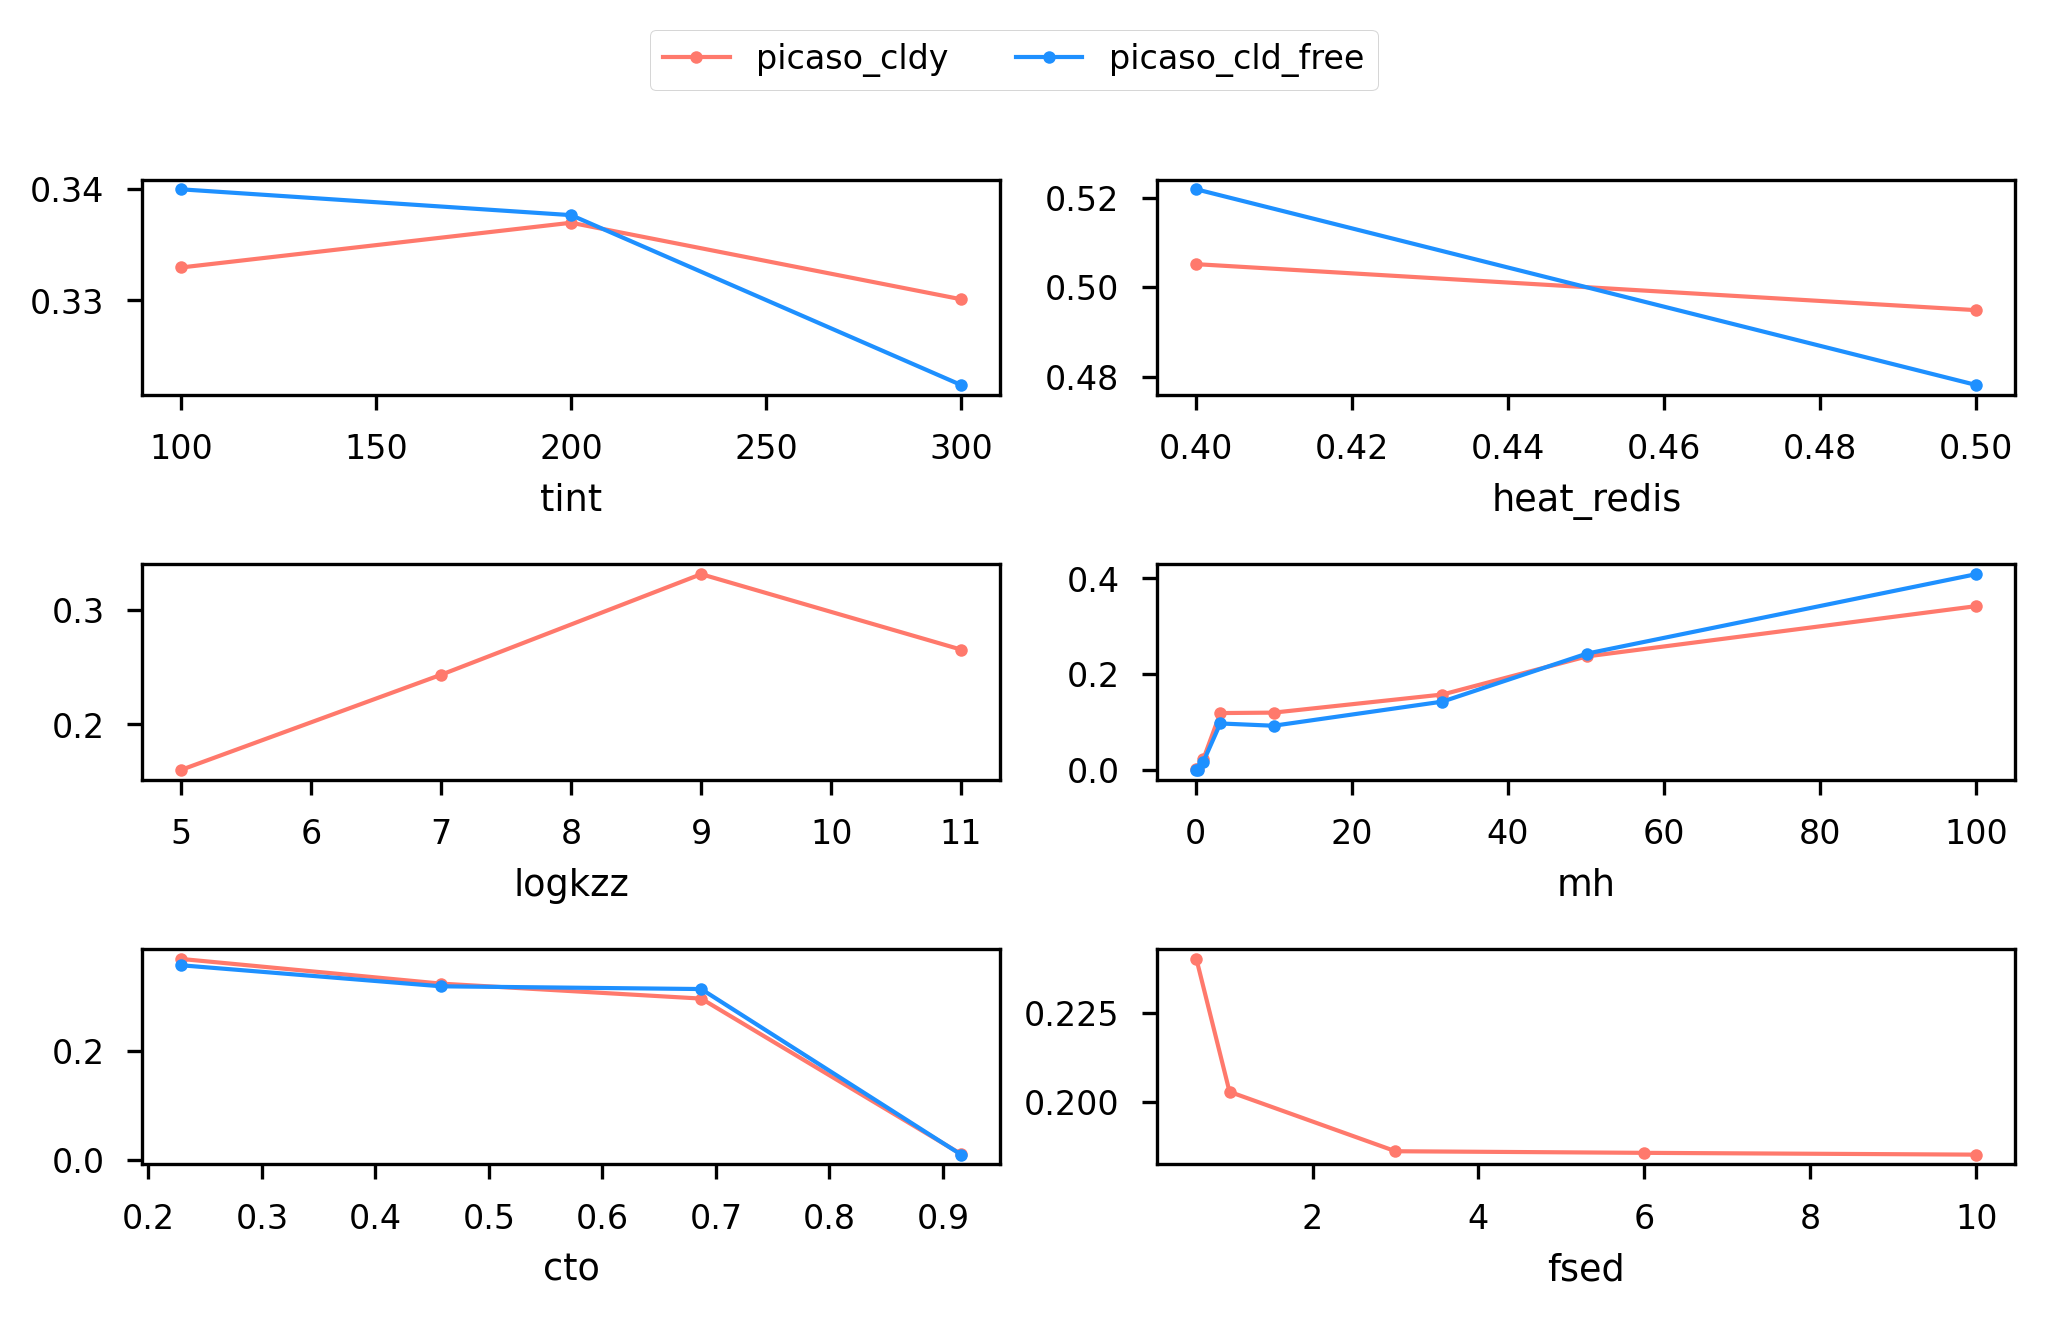

In [35]:
posterior_chance_dict, fig = fitter.plot_chi_posteriors(['picaso_cldy', 'picaso_cld_free'], 
                                                        'firefly', max_row=3, max_col=2, input_parameters='all')

In [36]:
posterior_chance_dict

{'picaso_cldy': {'tint': {'100.0'},
  'heat_redis': {'0.4'},
  'logkzz': {'9.0'},
  'mh': {'100.0'},
  'cto': {'0.229'},
  'fsed': {'0.6'}},
 'picaso_cld_free': {'tint': {'100.0'},
  'heat_redis': {'0.4'},
  'logkzz': {'9.0'},
  'mh': {'100.0'},
  'cto': {'0.229'},
  'fsed': {'0.6'}}}

What can you take away from this plot? 
1. Cloudy models reduce the number of models that can be fit to the data with high metallicity
2. Internal temperature cannot be constrained by the data 
3. C/O ratios greater than ~0.8 can be ruled out by the data

## Interpret Best Fit

Now that we are happy with the best-fitting model, we can load in that data and post process some plots in order to gain better understanding of our results.

We can use `PICASO`'s `xarray` loader to quickly load in one of our models. 

In [18]:
#grab top model 
top_model_file  = np.array(out['list_of_files']['picaso_cldy']
        )[out['rank_order']['picaso_cldy']['firefly']][0]

xr_usr = jdi.xr.load_dataset(top_model_file)
#take a look at the Xarray file 
xr_usr

<xarray.Dataset>
Dimensions:                         (pressure: 91, wavelength: 8988, pressure_cld: 90, wno_cld: 196)
Coordinates:
  * pressure                        (pressure) float64 1e-06 ... 1.8e+03
  * wavelength                      (wavelength) float64 6.0 5.998 ... 0.3001
  * pressure_cld                    (pressure_cld) float64 1.118e-06 ... 180.9
  * wno_cld                         (wno_cld) float64 43.95 72.05 ... 3.731e+04
Data variables: (12/54)
    opd                             (pressure_cld, wno_cld) float64 1.149e-10...
    ssa                             (pressure_cld, wno_cld) float64 4.654e-12...
    asy                             (pressure_cld, wno_cld) float64 9.452e-21...
    condensate_mmr_Na2S             (pressure_cld) float64 0.0 0.0 ... 0.0 0.0
    condensate_plus_gas_mmr_Na2S    (pressure_cld) float64 0.0001185 ... 0.00...
    mean_particle_r_Na2S            (pressure_cld) float64 0.0 0.0 ... 0.0 0.0
    ...                              ...
    OCS                             (pressure) float64 8.033e-09 ... 7.51e-09
    Li                              (pressure) float64 7.679e-12 ... 6.115e-09
    LiOH                            (pressure) float64 4.33e-10 ... 2.3e-09
    LiH                             (pressure) float64 2.283e-15 ... 7.35e-09
    LiCl                            (pressure) float64 6.089e-09 ... 4.201e-11
    transit_depth                   (wavelength) float64 0.02463 ... 0.02521
Attributes:
    author:          Sarah E. Moran
    contact:         semoran@lpl.arizona.edu
    code:            {"spectrum": "PICASO", "climate": "PICASO", "chemistry":...
    doi:             Mukherjee et al., submitted; Batalha et al., in prep
    planet_params:   {"rp": {"value": 1.279, "unit": "jupiterRad"}, "mp": {"v...
    stellar_params:  {"rs": {"value": 0.932, "unit": "solRad"}, "logg": 4.389...
    orbit_params:    {"sma": 0.0486}
    atmo_params:     {"mh": 0.5, "cto": 1.0}
    cld_params:      {"fsed": 0.6, "species": "Na2S, MnS, MgSiO3"}

In [19]:
opa = jdi.opannection(wave_range=[3,5])
case = jdi.input_xarray(xr_usr, opa)
#if you need to rerun your spectrum 
#out = case.spectrum(opa,calculation='transmisson')

### See Contribution From Each Molecule

One of the most common plots that was also used in the original paper is the "leave one out" method to see how each molecule is affecting our spectrum. 

In [20]:
#copy atmo before modifying and rerunning picaso
og_atmo = jdi.copy.deepcopy(case.inputs['atmosphere']['profile'])
#atmo
w,f,l =[],[],[]
for iex in ['CH4','H2O','CO2',None]:
    case.atmosphere(df = og_atmo,exclude_mol=iex, delim_whitespace=True)
    df= case.spectrum(opa, full_output=True,calculation='transmission') #note the new last key 
    wno, rprs2  = df['wavenumber'] , df['transit_depth']
    wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)
    w +=[wno]
    f+=[rprs2]
    if iex==None: 
        leg='all'
    else: 
        leg = f'No {iex}'
    l+=[leg]
jpi.show(jpi.spectrum(w,f,legend=l))

## Quantify Molecular Detection using Guassian Fitting


For very gaussian shaped molecules (like CO2 in this case), we can use a simple Gaussian fitting technique to quantify the significance of our detection. Note this ONLY works in cases where the shape of the molecule is gaussian with a single peak and well-shaped wings. 

/home/nbatalh1/anaconda3/envs/picaso38/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nbatalh1/anaconda3/envs/picaso38/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
8543it [00:27, 315.99it/s, +500 | bound: 26 | nc: 1 | ncall: 37518 | eff(%): 24.429 | loglstar:   -inf < -77.818 <    inf | logz: -94.155 +/-  0.180 | dlogz:  0.001 >  0.509]
2587it [00:11, 223.39it/s, +500 | bound: 2 | nc: 1 | ncall: 20018 | eff(%): 15.816 | loglstar:   -inf < -466.954 <    inf | logz: -471.221 +/-  0.074 | dlogz:  0.001 >  0.509]
/home/nbatalh1/anaconda3/envs/picaso38/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nbat

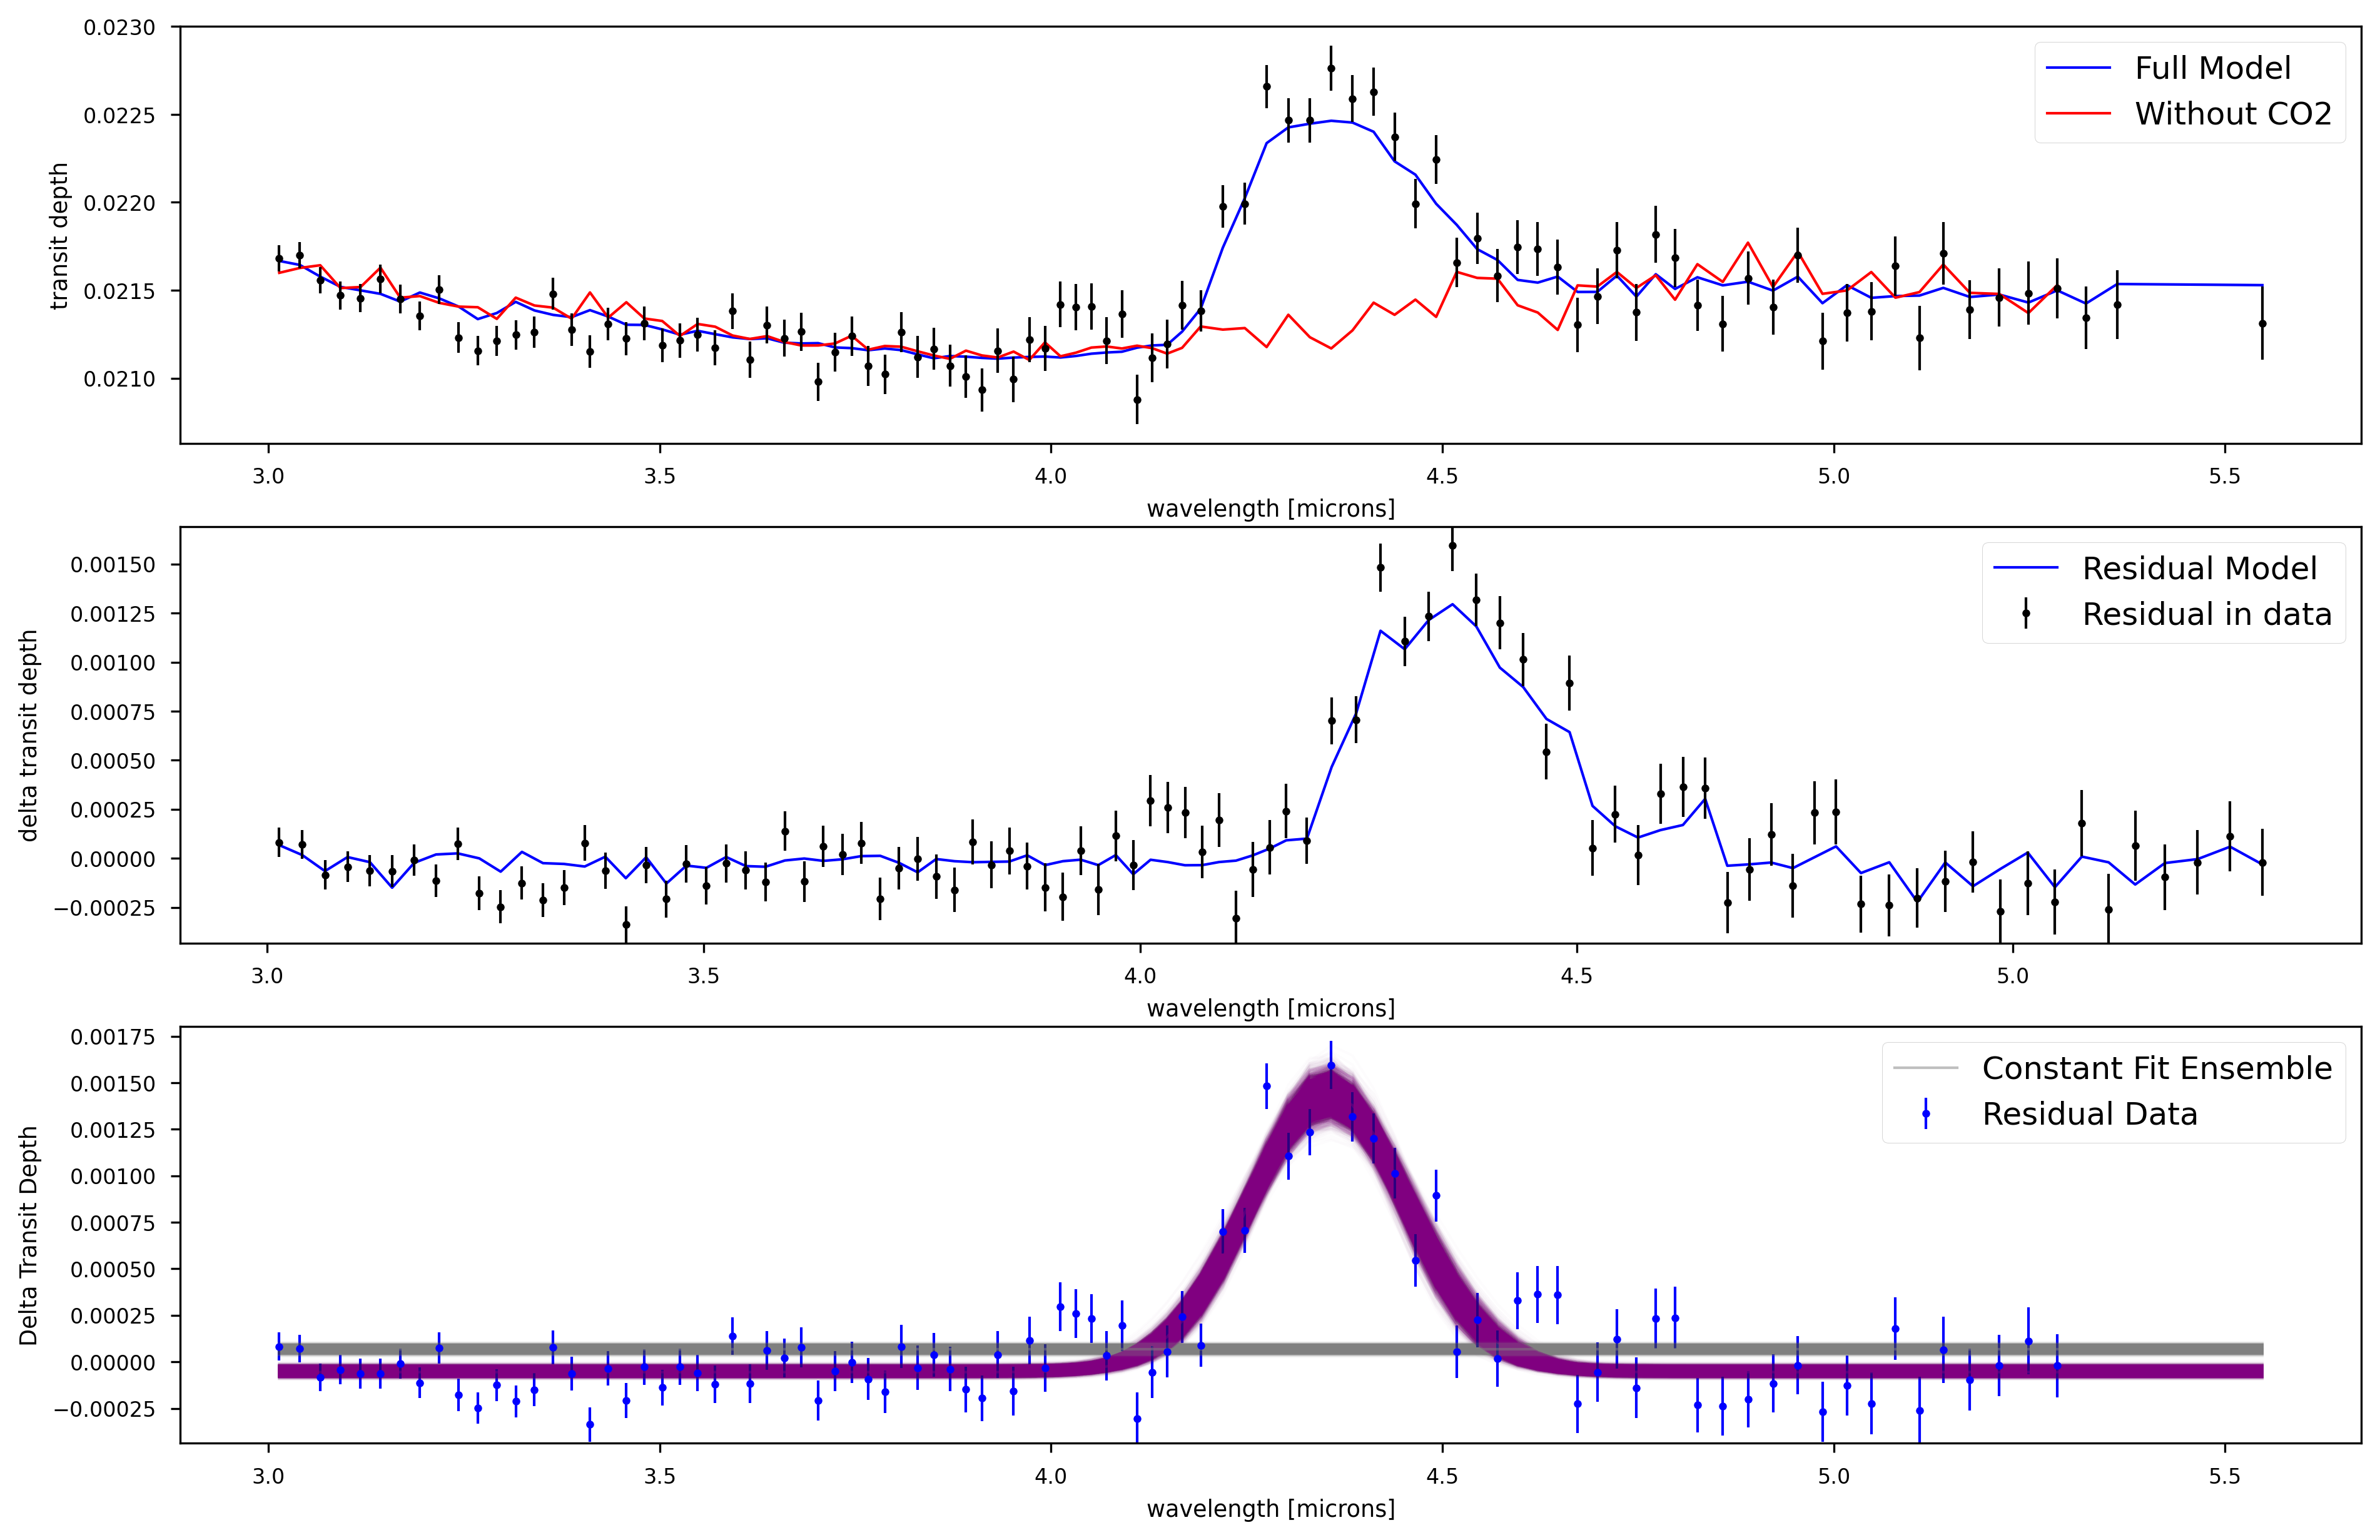

In [21]:
#grab file to test 
top_model_file  = np.array(out['list_of_files']['picaso_cldy']
        )[out['rank_order']['picaso_cldy']['firefly']][0]

min_wave = 3 #min wave to search for gauss peak
max_wave = 5 #max wave to search for gauss peak
out = lyz.detection_test(fitter,'CO2',min_wave,max_wave,'picaso_cldy','firefly',
                     top_model_file,
                     #opa_kwargs={wave_range=[]}#this is where you input arguments for opannection
                     plot=True)

By comparing the line fit to the single Gaussian fit, we can use the methodology of [Trotta 2008](https://ui.adsabs.harvard.edu/abs/2008ConPh..49...71T/abstract) to get out a sigma detection significance. In this case we can see that the single gaussian fit is preferred over the line model at 26 sigma.  

In [22]:
out['sigma_single_v_line']

27.585551284829965